In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from register import QuantumRegister
from gate import QuantumGate
from utils import plot_counts
from program_parser import parse_program

import matplotlib.pyplot as plt
from scipy.optimize import minimize

import numpy as np

import math

CUDARuntimeError: cudaErrorUnknown: unknown error

# Grover's Algorithm

## Without dedicated oracle qubit

In [3]:
quantum_reg = QuantumRegister(2)

In [4]:
circ = '../sample_circuits/Simple_grover.txt' # Grover oracle to look for string '11'

circ = parse_program(circ)

circ

[['h', [0, 1]],
 ['cz', [0, 1]],
 ['h', [0, 1]],
 ['z', [0, 1]],
 ['cz', [0, 1]],
 ['h', [0, 1]]]

[0, 1]


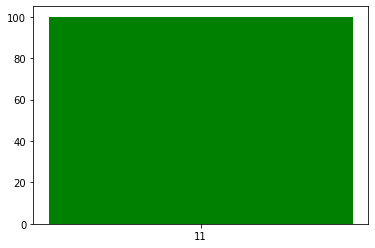

In [5]:
quantum_reg.run_program(circ)

plot_counts(quantum_reg.measure(100))

## With dedicated oracle qubit (Phase Kickback)

In [6]:
quantum_reg = QuantumRegister(3)

In [7]:
circ = '../sample_circuits/Grover_with_flip_qubit.txt' # Grover oracle to look for string '01'

circ = parse_program(circ)

circ

[['h', [2]],
 ['z', [2]],
 ['h', [0, 1]],
 ['x', [0]],
 ['ccx', [0, 1, 2]],
 ['x', [0]],
 ['h', [0, 1]],
 ['z', [0, 1]],
 ['cz', [0, 1]],
 ['h', [0, 1]]]

[0, 1]


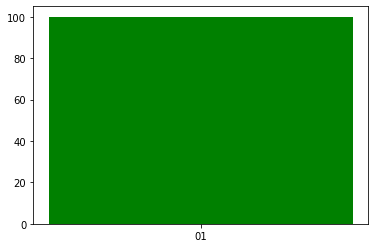

In [8]:
quantum_reg.run_program(circ)

plot_counts(quantum_reg.measure(100, [0,1]))

# Phase Estimation

Let's estimate the phase of the T gate, just like this [tutorial](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html).

In [9]:
reg = QuantumRegister(4)
reg.set_endianness('little') # we need to read the qubits in reverse order for this algorithm

In [10]:
phase_est = '../sample_circuits/Phase_estimation_T.txt' 
QFT = '../sample_circuits/QFT_3_qubits.txt' 

phase_est = parse_program(phase_est)
QFT = parse_program(QFT)

print(phase_est)
print(QFT)

[['h', [0, 1, 2]], ['x', [3]], ['ct', [0, 3]], ['ct', [1, 3]], ['ct', [1, 3]], ['ct', [2, 3]], ['ct', [2, 3]], ['ct', [2, 3]], ['ct', [2, 3]]]
[['h', [2]], ['crot', -1.57079632679, [1, 2]], ['crot', -0.78539816339, [0, 2]], ['h', [1]], ['crot', -1.57079632679, [0, 1]], ['h', [0]], ['swap', [0, 2]]]


In [11]:
reg.run_program(phase_est)

In [12]:
reg.run_program(QFT, reversed=True)

In [13]:
res = reg.measure(100, [2, 1, 0])

res

[1, 2, 3]


{'001': 100}

Convert to decimal

In [14]:
print('Phase coefficient:', (int(max(res.keys()), 2) / 2 ** 3))

Phase coefficient: 0.125


The result coincides with the phase caused with a T-gate.
$$T = \begin{pmatrix}
1 & 0\\ 
0 & e^{i \frac{\pi}{4}}
\end{pmatrix}$$

# Variational Algorithms

We will attempt to find an approximation of the ZY-decomposition of the Hadamard gate. We will use the SWAP test.

In [15]:
reg = QuantumRegister(3)

In [16]:
circ = '../sample_circuits/Variational_algorithm.txt'

circ = parse_program(circ)

circ

[['h', [0, 2]],
 ['rz', 'global_1', [1]],
 ['ry', 'global_2', [1]],
 ['rz', 'global_3', [1]],
 ['cswap', [0, 1, 2]],
 ['h', [0]]]

In [17]:
def objective_function(params):
    reg.reset()
    reg.run_program(circ, { "global_1": params[0], "global_2": params[1], "global_3": params[2] })

    counts = reg.measure(1000, [0])

    zeros = counts['0'] if '0' in counts.keys() else 0
    ones = counts['1'] if '1' in counts.keys() else 0

    ratio = ones / zeros
    
    return 1 - ratio

In [18]:
# initial values
params = np.array([1.5708, 1.5708, 1.5708])

In [24]:
%%capture
minimum = minimize(objective_function, params, method="Powell", tol=1e-6)

In [25]:
minimum

   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
     fun: array(-0.10970464)
 message: 'Optimization terminated successfully.'
    nfev: 158
     nit: 2
  status: 0
 success: True
       x: array([3.41249857, 1.69385558, 3.32266559])

Let's test the approximated angles.

In [26]:
params = minimum.x

[0]


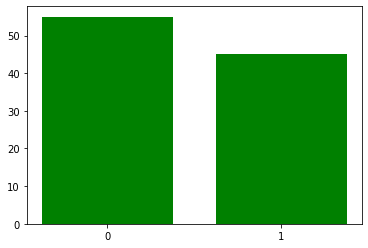

In [28]:
reg.reset()
reg.run_program(circ, { "global_1": params[0], "global_2": params[1], "global_3": params[2] })
plot_counts(reg.measure(100, [0]))